# STATISTICAL LEARNING PROJECT:

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

import seaborn as sns


In [126]:
# carico il dataset e stampo l'head
df= pd.read_csv("f1_pitstops_2018_2024.csv")

df.head()

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,Race Name,...,Tire Usage Aggression,Fast Lap Attempts,Position Changes,Driver Aggression Score,Abbreviation,Stint,Tire Compound,Stint Length,Pit_Lap,Pit_Time
0,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,1.0,ULTRASOFT,25.0,26.0,21.787
1,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,2.0,SOFT,32.0,NaN,Final Stint
2,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,1.0,ULTRASOFT,17.0,19.0,21.821
3,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,2.0,SOFT,39.0,NaN,Final Stint
4,2018,1,Albert Park Grand Prix Circuit,Kimi RÃƒÂ¤ikkÃƒÂ¶nen,Ferrari,58,3,1,21.421,Australian Grand Prix,...,0.017241,45.13482,0.086957,6.818562,RAI,1.0,ULTRASOFT,17.0,18.0,21.421


In [127]:
df.columns

Index(['Season', 'Round', 'Circuit', 'Driver', 'Constructor', 'Laps',
       'Position', 'TotalPitStops', 'AvgPitStopTime', 'Race Name', 'Date',
       'Time_of_race', 'Location', 'Country', 'Air_Temp_C', 'Track_Temp_C',
       'Humidity_%', 'Wind_Speed_KMH', 'Lap Time Variation', 'Total Pit Stops',
       'Tire Usage Aggression', 'Fast Lap Attempts', 'Position Changes',
       'Driver Aggression Score', 'Abbreviation', 'Stint', 'Tire Compound',
       'Stint Length', 'Pit_Lap', 'Pit_Time'],
      dtype='object')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   7374 non-null   int64  
 1   Round                    7374 non-null   int64  
 2   Circuit                  7374 non-null   object 
 3   Driver                   7374 non-null   object 
 4   Constructor              7374 non-null   object 
 5   Laps                     7374 non-null   int64  
 6   Position                 7374 non-null   int64  
 7   TotalPitStops            7374 non-null   int64  
 8   AvgPitStopTime           7189 non-null   float64
 9   Race Name                7001 non-null   object 
 10  Date                     7001 non-null   object 
 11  Time_of_race             7001 non-null   object 
 12  Location                 7001 non-null   object 
 13  Country                  7001 non-null   object 
 14  Air_Temp_C              

In [129]:
# Let's look at basic statistics
print(df.describe())


            Season        Round         Laps     Position  TotalPitStops  \
count  7374.000000  7374.000000  7374.000000  7374.000000    7374.000000   
mean   2021.308245    10.673312    56.643748    10.156089       2.068348   
std       1.969604     6.135126    13.922667     5.590062       1.135088   
min    2018.000000     1.000000     0.000000     1.000000       0.000000   
25%    2020.000000     5.000000    52.000000     5.000000       1.000000   
50%    2021.000000    11.000000    57.000000    10.000000       2.000000   
75%    2023.000000    15.000000    66.000000    15.000000       3.000000   
max    2024.000000    24.000000    87.000000    20.000000       7.000000   

       AvgPitStopTime   Air_Temp_C  Track_Temp_C   Humidity_%  Wind_Speed_KMH  \
count     7189.000000  7001.000000   7001.000000  7001.000000     7001.000000   
mean       120.109095    19.520345     25.207104    67.576191       11.434032   
std        268.723688     5.092982      5.195562    14.157319        6.0

## Check if the data contains any missing values

In [130]:
# Controllo i dati nulli
columnsWithNulls=df.isnull().sum().sort_values(ascending=False)
columnsWithNulls=columnsWithNulls[columnsWithNulls>0]
print(columnsWithNulls)

Pit_Lap                    2810
Track_Temp_C                373
Date                        373
Wind_Speed_KMH              373
Humidity_%                  373
Air_Temp_C                  373
Country                     373
Location                    373
Time_of_race                373
Race Name                   373
Pit_Time                    281
AvgPitStopTime              185
Lap Time Variation          185
Driver Aggression Score     185
Fast Lap Attempts           185
Stint Length                109
Tire Compound               109
Stint                       109
Tire Usage Aggression        66
dtype: int64


In [131]:
# Controllo in percentuale quanti dati mancano così da capire come trattarli, pongo una soglia di eliminazione del regressore nel caso di +30% di dati mancanti
missing_pct = df.isnull().mean() * 100
missing_only = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_only)


Pit_Lap                    38.106862
Wind_Speed_KMH              5.058313
Date                        5.058313
Time_of_race                5.058313
Location                    5.058313
Country                     5.058313
Air_Temp_C                  5.058313
Track_Temp_C                5.058313
Humidity_%                  5.058313
Race Name                   5.058313
Pit_Time                    3.810686
Fast Lap Attempts           2.508815
Driver Aggression Score     2.508815
Lap Time Variation          2.508815
AvgPitStopTime              2.508815
Stint                       1.478167
Tire Compound               1.478167
Stint Length                1.478167
Tire Usage Aggression       0.895037
dtype: float64


In [132]:
#droppiamo le righe con i valori nulli e le colonne con più del 30% di dati nulli
df.dropna(axis=0, inplace=True)
df.drop(columns=missing_only[missing_only>30].index, inplace=True)
df.isnull().sum()


Season                     0
Round                      0
Circuit                    0
Driver                     0
Constructor                0
Laps                       0
Position                   0
TotalPitStops              0
AvgPitStopTime             0
Race Name                  0
Date                       0
Time_of_race               0
Location                   0
Country                    0
Air_Temp_C                 0
Track_Temp_C               0
Humidity_%                 0
Wind_Speed_KMH             0
Lap Time Variation         0
Total Pit Stops            0
Tire Usage Aggression      0
Fast Lap Attempts          0
Position Changes           0
Driver Aggression Score    0
Abbreviation               0
Stint                      0
Tire Compound              0
Stint Length               0
Pit_Time                   0
dtype: int64

## Data Preprocessing

## Correlation HeatMap 

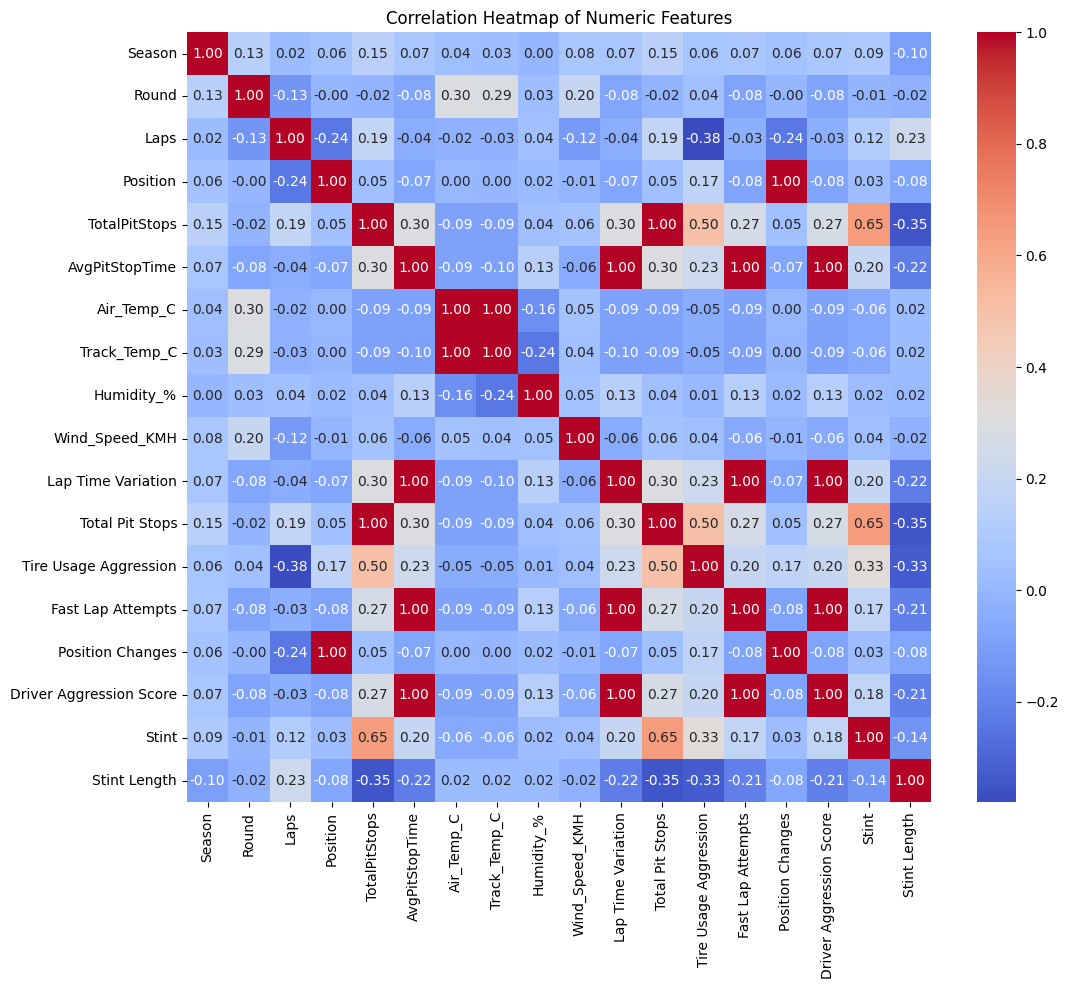

In [133]:
# Generate correlation heatmap for numeric features
numeric_df = df.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')


Air_Temp_C vs Track_Temp_C: 1.00 → sono identiche o derivano strettamente l’una dall’altra. Togli una delle due.

AvgPitStopTime vs Lap Time Variation: 1.00 → molto probabilmente hai sovrascritto una colonna con l’altra, o la “Lap Time Variation” è in realtà lo stesso metric. Verifica la definizione e mantieni una sola.

TotalPitStops vs Total Pit Stops: 1.00 → doppione; elimina la colonna con lo spazio o senza in modo da non confonderti.

In [134]:
# 1. Seleziona solo le colonne numeriche e calcola la correlazione assoluta
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr().abs()

# 2. Prendi la metà superiore (senza diagonale)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 3. Trova tutte le colonne con corr > 0.99
to_drop = [col for col in upper.columns if any(upper[col] > 0.99)]
print("Tutte le colonne candidate al drop:", to_drop)

# 4. Rimuovi 'Driver Aggression Score' dalla lista, se presente
to_drop = [col for col in to_drop if col != "Driver Aggression Score"]
print("Colonne da droppare (escl. Driver Aggression Score):", to_drop)

# 5. Droppa solo le restanti
df.drop(columns=to_drop, inplace=True)

# 6. Droppiamo AvgPitStopTime
df.drop(columns=['AvgPitStopTime'], inplace=True)



Tutte le colonne candidate al drop: ['Track_Temp_C', 'Lap Time Variation', 'Total Pit Stops', 'Fast Lap Attempts', 'Position Changes', 'Driver Aggression Score']
Colonne da droppare (escl. Driver Aggression Score): ['Track_Temp_C', 'Lap Time Variation', 'Total Pit Stops', 'Fast Lap Attempts', 'Position Changes']


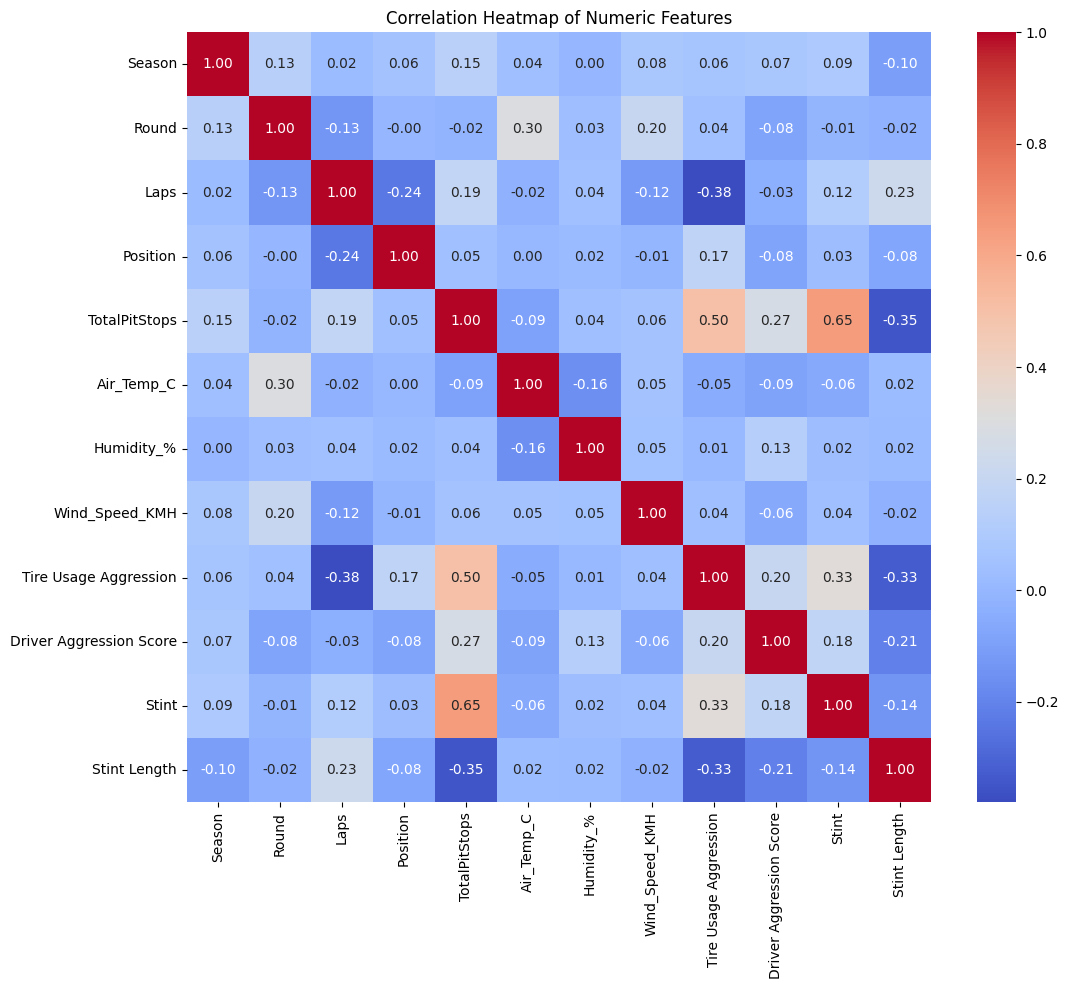

In [135]:
# Generate correlation heatmap for numeric features
numeric_df = df.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')


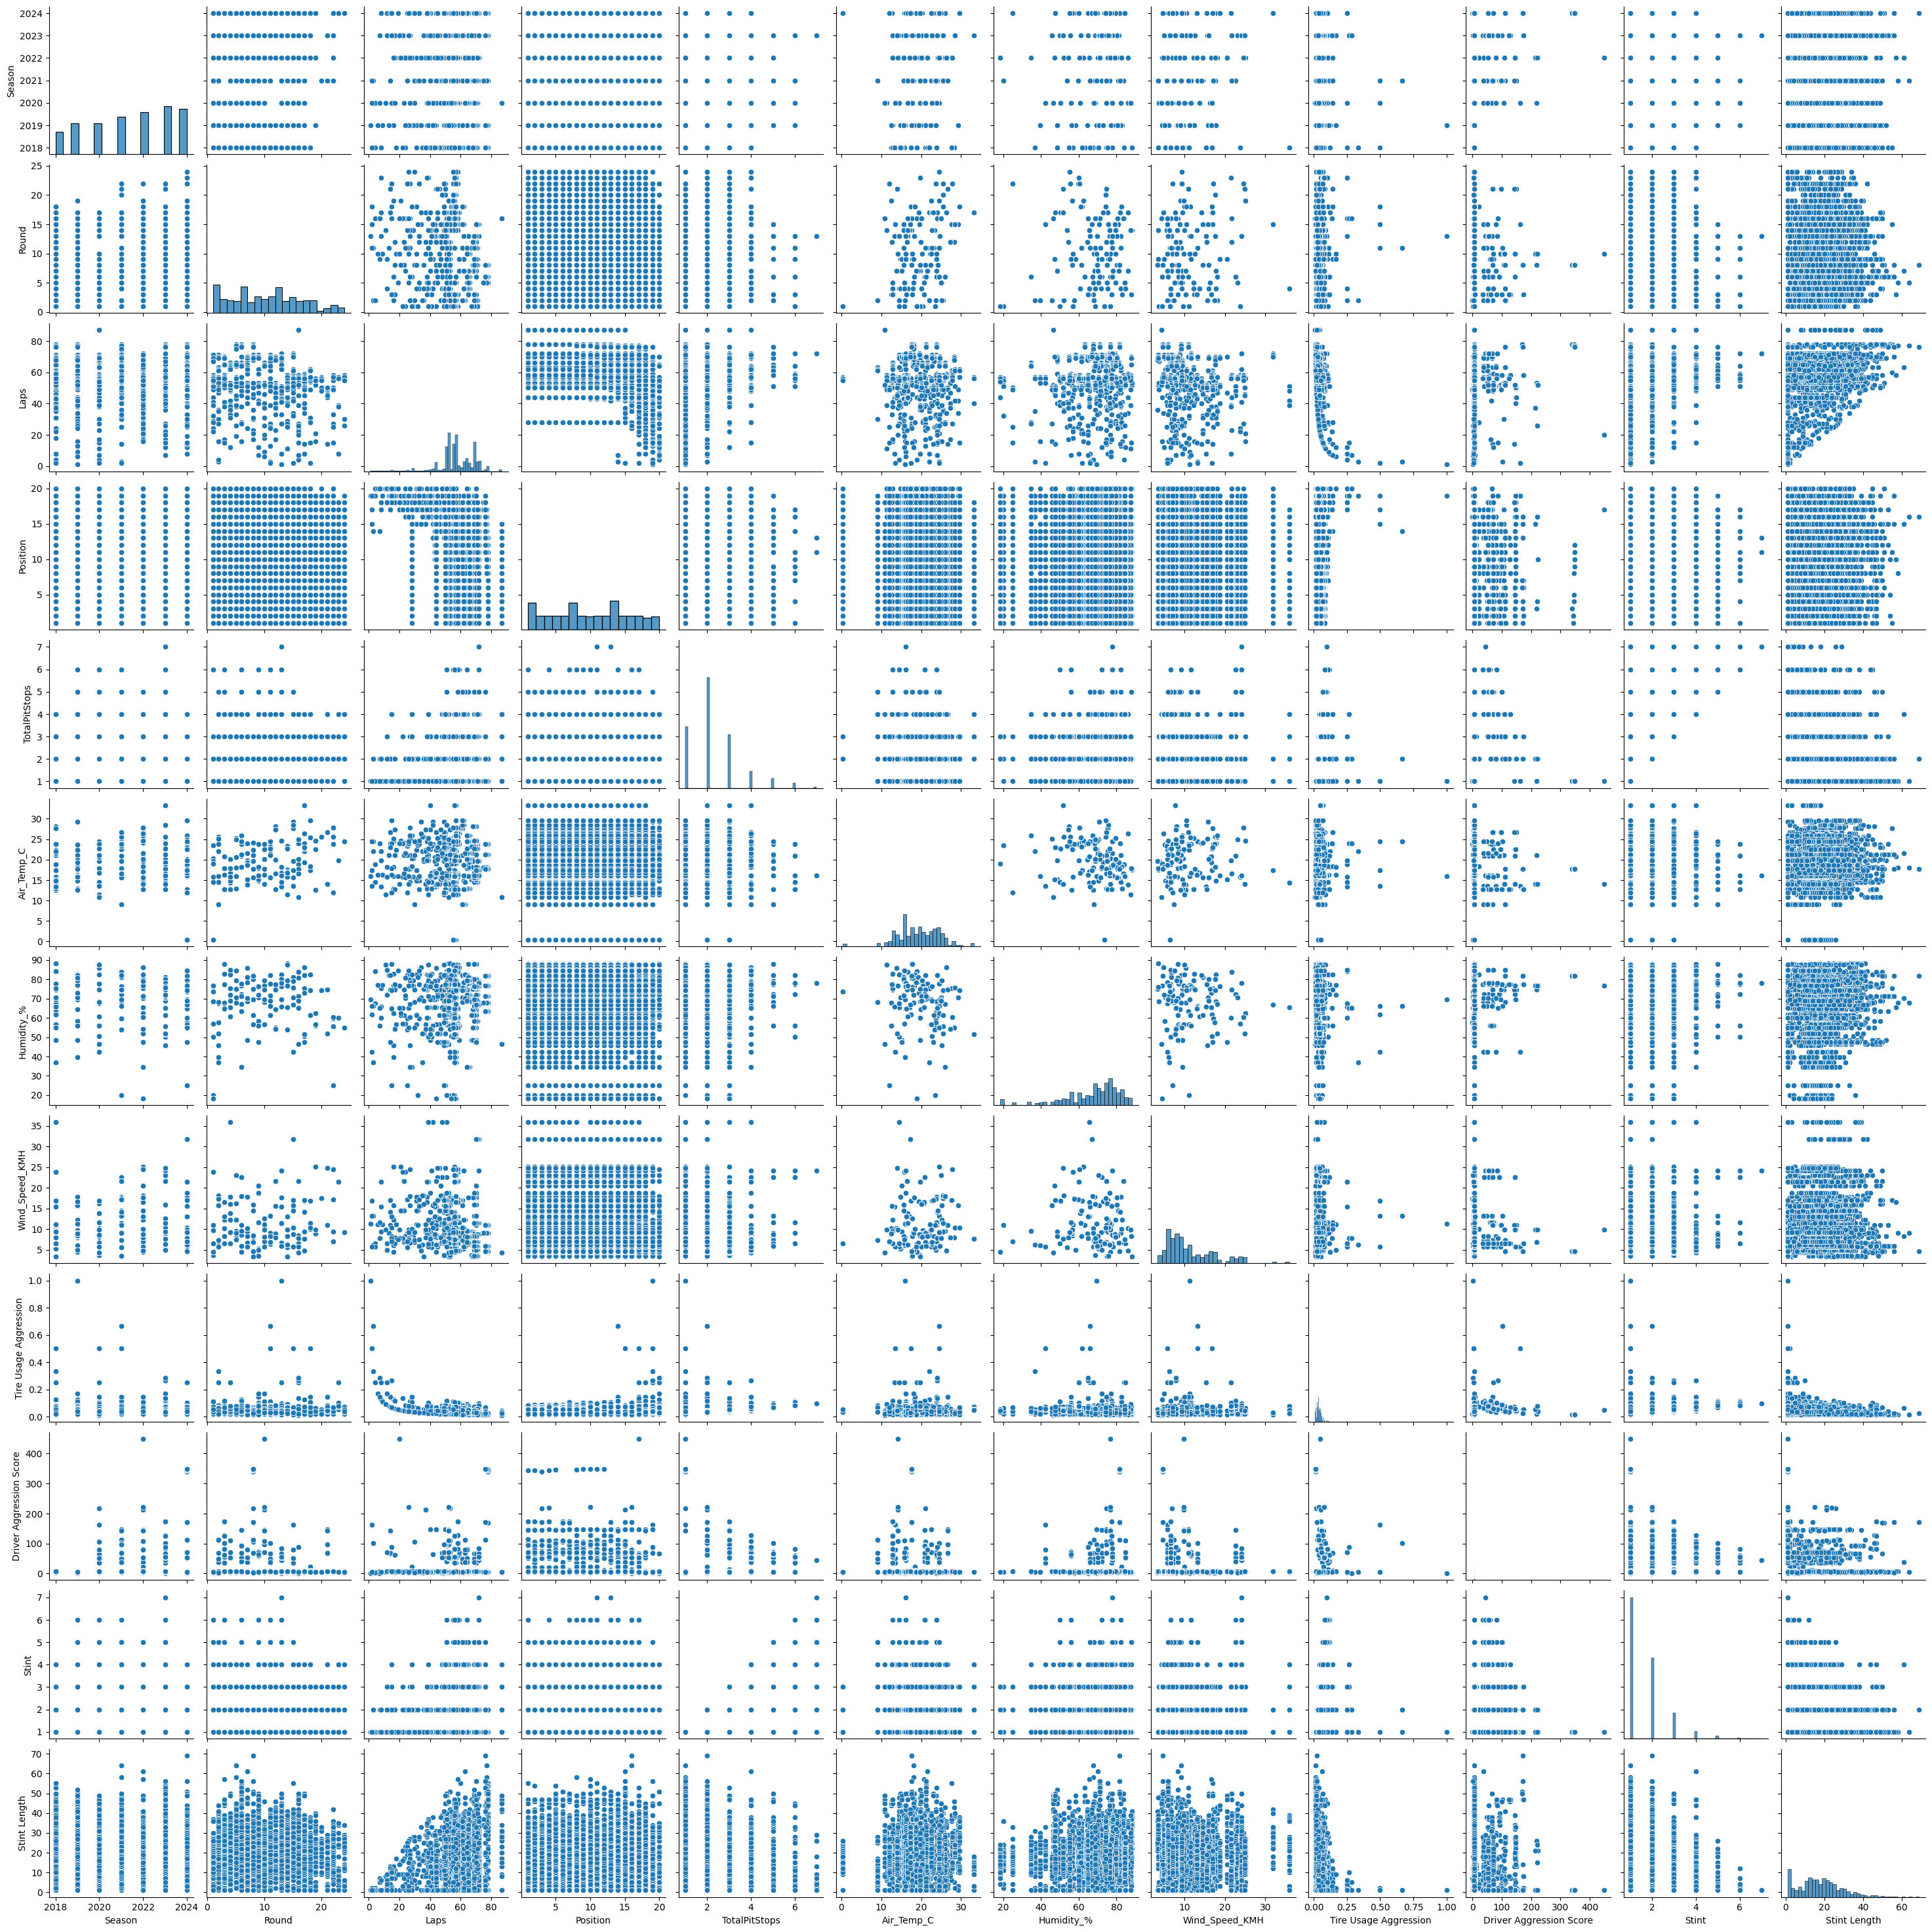

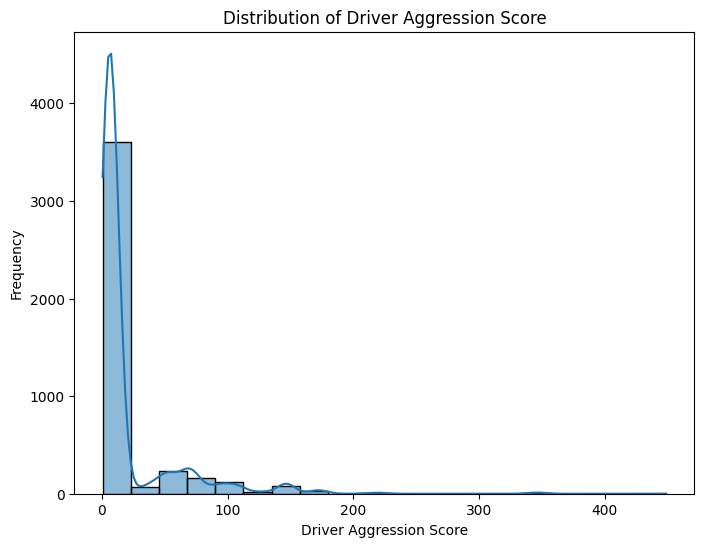

In [136]:
# Pair Plot for selected numeric features for a quick visual insight

sns.pairplot(df)
plt.show()

# Histograms: Distribution of the 'Driver Aggression Score'
plt.figure(figsize=(8, 6))
sns.histplot(df['Driver Aggression Score'], kde=True, bins=20)
plt.title('Distribution of Driver Aggression Score')
plt.xlabel('Driver Aggression Score')
plt.ylabel('Frequency')
plt.show()